# STXS 1.2 Scale Variations Uncertainties

The STXS Stage 1.2 uncertainties are computed by means of scale variations.
As at the time of writing this I didn't find any NanoAOD with STXS 1.2 implemented, I am using the ggH ntuple produced with the [HZZ4L code](https://github.com/CJLST/ZZAnalysis) code.
Here we have STXS 1.2 implemented according to [cms-sw recipe](https://github.com/cms-sw/cmssw/blob/master/SimDataFormats/HTXS/interface/HiggsTemplateCrossSections.h#L297). The scale variations in each STXS bin should be consistent with the gen-level ones, as we consider ratios between nominal and scaled values.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd
import uproot

In [2]:
url = 'https://gist.githubusercontent.com/bonanomi/d14780f7562cb2a22fdd753a9d4459d4/raw/b3c6d77505b90eb38a886c19a31725df8ceb908f/MyMPLStyle'
plt.style.use(url)

In [3]:
eos_dir = '/eos/cms/store/group/phys_higgs/cmshzz4l/cjlst/RunIILegacy/200205_CutBased/MC_2016/ggH125/'
file    = 'ZZ4lAnalysis.root'

As first step, we import the `TTree` used later on. This is a `ggH` ($m_H=125$ GeV) sample produced from `miniAOD` sim files.
We are only interested in few branches, namely:
 * STXS Stage 1.2 categorization;
 * QCD weights corresponding at renormalization ($\mu_R$) and factorization ($\mu_F$) scale variations;
For consistency with what we have done for the STXS 1.1, using a `NanoAOD` sim file, we import all the scale variations. However, we do not consider the extreme scale variations, i.e. those for which $\mu_R\mu_F = 2$ (see e.g. [here](https://cernbox.cern.ch/index.php/s/lq8XUoJ4WjDCPlL) for further information about STXS uncertainties scheme).

For each STXS bin, we are going to compute the ratio between the scale varied yield in that bin and the corresponding nominal value.

In [4]:
tree = 'ZZTree/candTree'
fname = eos_dir + file
branches = ['htxs_stage1p2_cat', 'LHEweight_QCDscale_muR0p5_muF0p5', 
            'LHEweight_QCDscale_muR0p5_muF1', 'LHEweight_QCDscale_muR0p5_muF2',
            'LHEweight_QCDscale_muR1_muF0p5', 'LHEweight_QCDscale_muR1_muF1', 
            'LHEweight_QCDscale_muR1_muF2', 'LHEweight_QCDscale_muR2_muF0p5',
            'LHEweight_QCDscale_muR2_muF1', 'LHEweight_QCDscale_muR2_muF2']
weights = [ b'LHEweight_QCDscale_muR0p5_muF0p5', 
            b'LHEweight_QCDscale_muR0p5_muF1', b'LHEweight_QCDscale_muR0p5_muF2',
            b'LHEweight_QCDscale_muR1_muF0p5', b'LHEweight_QCDscale_muR1_muF1', 
            b'LHEweight_QCDscale_muR1_muF2', b'LHEweight_QCDscale_muR2_muF0p5',
            b'LHEweight_QCDscale_muR2_muF1', b'LHEweight_QCDscale_muR2_muF2']

In [5]:
evt = uproot.open(fname)[tree]
evts = evt.arrays(branches)

## Loading the TTree and reading STXS bins

We load the TTree and to be sure of including all the STXS categories, we use a large binning. Knowing *a priori* the values of the STXS bins, one could make a wiser choice here. However it does not affect what follows. The `h_stxs` histogram contains the information about the STXS categories, while in the `d` dictionary, we store the values of $\mu_R,\, \mu_F$  scale variations per event. We use the same convention as of `NanoAOD` files:
 * `0`: $\mu_R$ = 0.5, $\mu_F$ = 0.5,
 * `1`: $\mu_R$ = 0.5, $\mu_F$ = 1, 
 * `2`: $\mu_R$ = 0.5, $\mu_F$ = 2,
 * `3`: $\mu_R$ = 1, $\mu_F$ = 0.5, 
 * `4`: $\mu_R$ = 1, $\mu_F$ = 1, 
 * `5`: $\mu_R$ = 1, $\mu_F$ = 2, 
 * `6`: $\mu_R$ = 2, $\mu_F$ = 0.5,
 * `7`: $\mu_R$ = 2, $\mu_F$ = 1, 
 * `8`: $\mu_R$ = 2, $\mu_F$ = 2

In [6]:
binning = np.linspace(0, 500, 500)

In [7]:
h_stxs = np.histogram(evts[b'htxs_stage1p2_cat'], binning)

In [8]:
d = {}
for w in enumerate(weights):
    i = w[0]; weight = w[1]
    d[i] = evts[weight]

We compute the reweighted histograms of the STXS classification and we store them in `d_scales`. Again, each one of these histos has 500 bins, but most of them will be empty.

In [9]:
%%time
d_scales = {}
for i in range(9):
    d_scales[i] = np.histogram(evts[b'htxs_stage1p2_cat'], binning, weights=d[i])

CPU times: user 45 ms, sys: 1.72 ms, total: 46.7 ms
Wall time: 47.1 ms


We compute the nominal yield for each STXS bin. Here we save only the non null values.

In [10]:
int_nominal = [i for i in h_stxs[0] if i!=0]

We also store the yield of each STXS bin corresponding to the different values of the $\mu_R,\, \mu_F$ scale variations. As mentioned above, we are not considering the values corresponding to *extreme* scale variations, i.e. those for which $\mu_R \mu_F = 2$. For the convention we are using, these correspond to the indexes `2` and `6`. Note that index `4` correspond to the nominal value. Hence we expect to retrieve a null uncertainty for this scale variation (i.e. ratio w.r.t `int_nominal` equal to one in all the STXS bins).

In [11]:
%%time
int_scale = {}
for i in range(9):
    if (i==2) | (i==6):
        continue
    int_scale[i] = [j for j, k in zip(d_scales[i][0], h_stxs[0]) if k != 0]

CPU times: user 3.54 ms, sys: 5 µs, total: 3.55 ms
Wall time: 3.4 ms


In [12]:
bins_c =  0.5*(h_stxs[1][1:]+h_stxs[1][:-1])

In [13]:
stxs_bins = [round(j, 0) for i, j in zip(h_stxs[0], bins_c) if i!=0]

## Yields in STXS bins 

Simple printout of the yields in each STXS bin, both for the nominal values and all the scaled variations. Below we print the relative scale variation w.r.t the nominal value. 

In [39]:
print('STXS\t Nominal\t DD\t\t DN\t\t ND\t\t NN\t\t NU\t\t UN\t\t UU')

for stxs, nom_int in zip(enumerate(stxs_bins), int_nominal):
    k = stxs[0]; stxs_bin = stxs[1]
    print('[{}] => {} :::\t'.format(int(stxs_bin), nom_int), end='')
    for i in range(9):
        if (i==2) | (i==6):
            continue
        print(' {0:.2f}, \t'.format(int_scale[i][k]), end='')
    print('\n')

STXS	 Nominal	 DD		 DN		 ND		 NN		 NU		 UN		 UU
[101] => 2061 :::	 2917.33, 	 2776.52, 	 2161.33, 	 2061.00, 	 1963.50, 	 1578.35, 	 1506.26, 	

[102] => 705 :::	 1045.53, 	 958.76, 	 767.88, 	 705.00, 	 649.81, 	 534.97, 	 493.65, 	

[103] => 134 :::	 209.63, 	 183.57, 	 152.99, 	 134.00, 	 118.43, 	 100.95, 	 89.23, 	

[104] => 15 :::	 24.29, 	 20.57, 	 17.71, 	 15.00, 	 12.88, 	 11.29, 	 9.69, 	

[105] => 15066 :::	 17163.01, 	 17803.18, 	 14465.83, 	 15066.00, 	 15569.12, 	 12904.88, 	 13356.48, 	

[106] => 57684 :::	 66072.45, 	 68454.95, 	 55457.02, 	 57684.00, 	 59532.43, 	 49259.72, 	 50920.08, 	

[107] => 16377 :::	 19159.78, 	 19761.13, 	 15818.53, 	 16377.00, 	 16821.23, 	 13813.34, 	 14211.98, 	

[108] => 11124 :::	 13564.70, 	 13870.88, 	 10837.10, 	 11124.00, 	 11325.29, 	 9136.87, 	 9317.84, 	

[109] => 2220 :::	 2945.94, 	 2917.92, 	 2236.47, 	 2220.00, 	 2191.51, 	 1743.77, 	 1723.40, 	

[110] => 2375 :::	 2819.95, 	 2900.53, 	 2300.72, 	 2375.00, 	 2431.91, 	 1984.34,

In [40]:
print('STXS\t Nominal\t DD\t\t DN\t\t ND\t\t NN\t\t NU\t\t UN\t\t UU')
for stxs, nom_int in zip(enumerate(stxs_bins), int_nominal):
    k = stxs[0]; stxs_bin = stxs[1]
    print('[{}] => {} :::\t'.format(int(stxs_bin), nom_int), end='')
    for i in range(9):
        if (i==2) | (i==6):
            continue
        norm_stxs = (int_scale[i][k] - nom_int)/nom_int * 1e2
        print(' {0:.2f}%, \t'.format(norm_stxs), end='')
    print('\n')

STXS	 Nominal	 DD		 DN		 ND		 NN		 NU		 UN		 UU
[101] => 2061 :::	 41.55%, 	 34.72%, 	 4.87%, 	 0.00%, 	 -4.73%, 	 -23.42%, 	 -26.92%, 	

[102] => 705 :::	 48.30%, 	 35.99%, 	 8.92%, 	 0.00%, 	 -7.83%, 	 -24.12%, 	 -29.98%, 	

[103] => 134 :::	 56.44%, 	 36.99%, 	 14.17%, 	 0.00%, 	 -11.62%, 	 -24.67%, 	 -33.41%, 	

[104] => 15 :::	 61.93%, 	 37.14%, 	 18.07%, 	 0.00%, 	 -14.12%, 	 -24.74%, 	 -35.38%, 	

[105] => 15066 :::	 13.92%, 	 18.17%, 	 -3.98%, 	 0.00%, 	 3.34%, 	 -14.34%, 	 -11.35%, 	

[106] => 57684 :::	 14.54%, 	 18.67%, 	 -3.86%, 	 0.00%, 	 3.20%, 	 -14.60%, 	 -11.73%, 	

[107] => 16377 :::	 16.99%, 	 20.66%, 	 -3.41%, 	 0.00%, 	 2.71%, 	 -15.65%, 	 -13.22%, 	

[108] => 11124 :::	 21.94%, 	 24.69%, 	 -2.58%, 	 0.00%, 	 1.81%, 	 -17.86%, 	 -16.24%, 	

[109] => 2220 :::	 32.70%, 	 31.44%, 	 0.74%, 	 0.00%, 	 -1.28%, 	 -21.45%, 	 -22.37%, 	

[110] => 2375 :::	 18.73%, 	 22.13%, 	 -3.13%, 	 0.00%, 	 2.40%, 	 -16.45%, 	 -14.30%, 	

[111] => 5210 :::	 23.45%, 	 25.72%, 	 -2.14%, 	

## Saving to file and plotting

We create `integrals` dictionary to store the information about the STXS yields corresponding to the different scale variations. We use this value later on to store the yields and the relative variations to files. In integrals we have:
```
 integrals = { 0: {101: yield_101, 102: yield_102, ecc}
               ...
               8: {101: yield_101, 102: yield_102, ecc}
             }
```

In [16]:
integrals = {i: {int(k): [] for k in stxs_bins} for i in range(9) if ((i!= 2) & (i!= 6))}
for stxs, nom_int in zip(enumerate(stxs_bins), int_nominal):
    k = stxs[0]; stxs_bin = int(stxs[1])
    for i in range(9):
        if (i==2) | (i==6):
            continue
        int_varied = int_scale[i][k]
        integrals[i][stxs_bin] = (int_varied)

In [17]:
# for i in range(9):
#     if (i==2) | (i==6):
#         continue

#     integrals[i][104] += integrals[i][105]
#     integrals[i][104] += integrals[i][106]
#     integrals[i][104] += integrals[i][107]
    
#     integrals[i][108] += integrals[i][109]
#     integrals[i][108] += integrals[i][110]
#     integrals[i][108] += integrals[i][111]
#     integrals[i][108] += integrals[i][101]
#     integrals[i][108] += integrals[i][102]

In [41]:
!pwd

/eos/home-m/mbonanom/SWAN_projects/STXS


In [18]:
yields = open("Yields_1p2.txt","w+")
yields.write('STXS\t\t DD \t\t DN \t\t ND \t\t NN \t\t NU \t\t UN \t\t UU')
yields.write('\n')

for stxs, nom_int in zip(enumerate(stxs_bins), int_nominal):
    k = stxs[0]; stxs_bin = int(stxs[1])
    yields.write('{} \t'.format(int(stxs_bin)))
    for i in range(9):
        if (i==2) | (i==6):
            continue
        yields.write('\t{0:.2f},\t ' .format(integrals[i][stxs_bin]))
    yields.write('\n')
yields.close()

In [19]:
normalization = open("Normalization_1p2.txt","w+")
normalization.write('STXS\t\t DD \t\t DN \t\t ND \t\t NN \t\t NU \t\t UN \t\t UU')
normalization.write('\n')
for stxs, nom_int in zip(enumerate(stxs_bins), int_nominal):
    k = stxs[0]; stxs_bin = int(stxs[1])
    normalization.write('{} \t'.format(int(stxs_bin)))
    for i in range(9):
        if (i==2) | (i==6):
            continue
        norm_int = nom_int/integrals[i][stxs_bin]
        normalization.write('\t{0:.2f},\t ' .format(norm_int))
    normalization.write('\n')
normalization.close()

In [20]:
histos = {}
for i in range(9):
    if (i==2) | (i==6):
        continue    
    values = []
    for stxs, nom_int in zip(enumerate(stxs_bins), int_nominal):
        k = stxs[0]; stxs_bin = int(stxs[1])
        norm_int = nom_int/integrals[i][stxs_bin]
        values.append(norm_int)
    histos[i] = values

In [21]:
scale_var = {
    0: r'$\mu_r$ = 0.5, $\mu_f$ = 0.5',
    1: r'$\mu_r$ = 0.5, $\mu_f$ = 1.0',
    3: r'$\mu_r$ = 1.0, $\mu_f$ = 0.5',
    4: r'$\mu_r$ = 1.0, $\mu_f$ = 1.0',
    5: r'$\mu_r$ = 1.0, $\mu_f$ = 2.0',
    7: r'$\mu_r$ = 2.0, $\mu_f$ = 1.0',
    8: r'$\mu_r$ = 2.0, $\mu_f$ = 2.0'
}

/usr/local/bin/start_ipykernel.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


Text(0, 1.0, '$\\sigma_{nom}/\\sigma_{var}$')

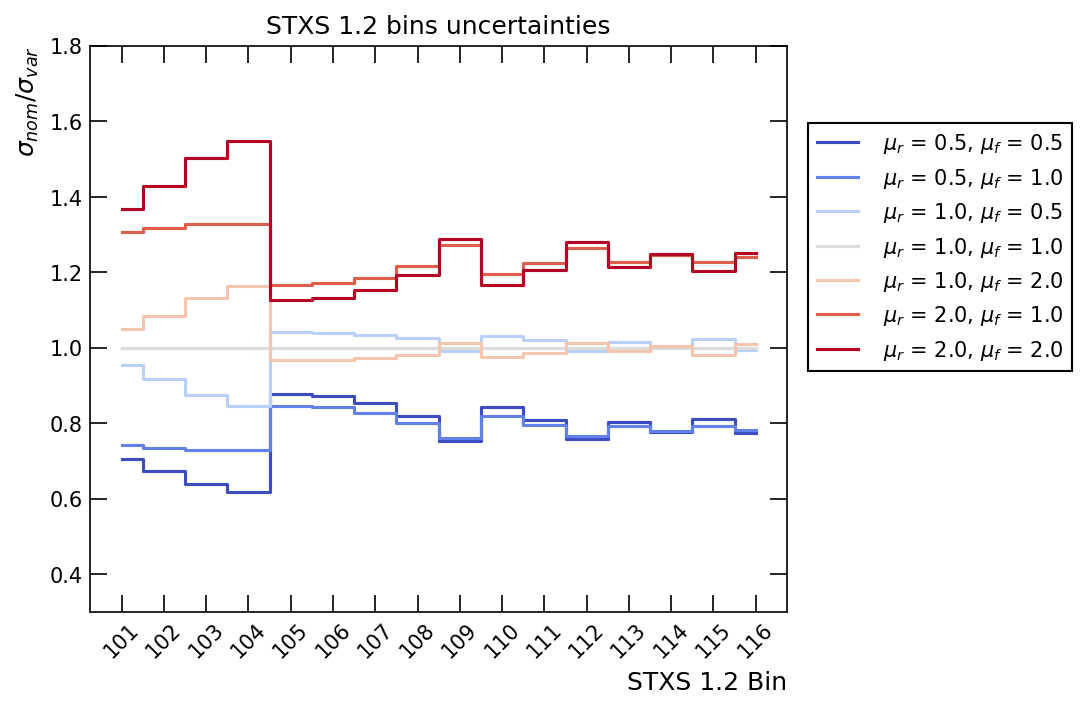

In [24]:
plt.figure(figsize = (6,5))
cmap = plt.cm.coolwarm(np.linspace(0, 1., 9.))
for i in range(9):
    if (i==2) | (i==6):
        continue
    plt.step(stxs_bins, histos[i], where = 'mid', label = scale_var[i], color = cmap[i], linewidth = 1.5)
    plt.grid(b = None)
plt.legend(bbox_to_anchor=(1., 0.9))
plt.xticks(stxs_bins, rotation = 45)
plt.tick_params(which='minor', length=0)
plt.ylim(0.3, 1.8)
plt.title('STXS 1.2 bins uncertainties')
plt.xlabel('STXS 1.2 Bin', ha='right', x=1.0, fontsize = 12)
plt.ylabel(r'$\sigma_{nom}/\sigma_{var}$', ha='right', y=1.0, fontsize = 12)